In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
import os
import findspark
os.environ["PYSPARK_PYTHON"] = "python3"
findspark.init("../../../spark-2.2.1-bin-hadoop2.7",)

## Data ETL and Data Exploration

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = (
    SparkSession.builder
        .master("local[*]")
        .appName("Spark Movie Recommendation Project")
        .getOrCreate()
)
sc = spark.sparkContext

In [5]:
movies = spark.read.load("ml-latest-small/movies.csv", format='csv', header = True)
ratings = spark.read.load("ml-latest-small/ratings.csv", format='csv', header = True)
links = spark.read.load("ml-latest-small/links.csv", format='csv', header = True)
tags = spark.read.load("ml-latest-small/tags.csv", format='csv', header = True)

In [6]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [7]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
+------+-------+------+----------+
only showing top 5 rows



In [8]:
print('Distinct values of ratings:')
print sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect())

Distinct values of ratings:
[u'0.5', u'1.0', u'1.5', u'2.0', u'2.5', u'3.0', u'3.5', u'4.0', u'4.5', u'5.0']


In [9]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [10]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3063 out of 9066 movies are rated by only one user


In [11]:
links.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [12]:
tags.show(5)

+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|    15|    339|sandra 'boring' b...|1138537770|
|    15|   1955|             dentist|1193435061|
|    15|   7478|            Cambodia|1170560997|
|    15|  32892|             Russian|1170626366|
|    15|  34162|         forgettable|1141391765|
+------+-------+--------------------+----------+
only showing top 5 rows



### Q1: The number of Users

In [13]:
ratings.select('userId').union(tags.select('userId')).distinct().count()

671

### Q2: The number of Movies

In [14]:
ratings.select('movieId').union(tags.select('movieId')).distinct().count()

9125

### Q3:  How many movies are rated by users? List movies not rated before

In [15]:
num_movies_rated = ratings.select('movieId').distinct().count()
num_movies_rated

9066

In [16]:
all_movies = ratings.select('movieId').union(tags.select('movieId'))
rated = ratings.select('movieId')
not_rated = all_movies.subtract(rated)
not_rated.distinct().show()

+-------+
|movieId|
+-------+
| 144172|
|  94969|
| 132547|
|   7335|
| 110871|
|   5984|
| 131796|
| 132800|
| 128235|
|  39421|
|  82313|
| 111251|
|  42217|
| 132549|
|   8767|
| 161582|
| 155064|
| 111249|
|  48711|
| 132458|
+-------+
only showing top 20 rows



### Q4: List Movie Genres

In [17]:
#movies.select('genres').map(lambda x: x[0].split('|')) ????? does not work
movies.select('genres').distinct().show()

+--------------------+
|              genres|
+--------------------+
|Comedy|Horror|Thr...|
|Adventure|Sci-Fi|...|
|Action|Adventure|...|
| Action|Drama|Horror|
|Comedy|Drama|Horr...|
|Action|Animation|...|
|Animation|Childre...|
|Action|Adventure|...|
| Adventure|Animation|
|    Adventure|Sci-Fi|
|Documentary|Music...|
|Adventure|Childre...|
|  Documentary|Sci-Fi|
| Musical|Romance|War|
|Action|Adventure|...|
|Adventure|Childre...|
|Crime|Drama|Fanta...|
|Comedy|Mystery|Th...|
|   Adventure|Fantasy|
|Action|Animation|...|
+--------------------+
only showing top 20 rows



### Q5: Movie for Each Category

In [18]:
movies.groupby("genres").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|              genres|count|
+--------------------+-----+
|               Drama| 1170|
|              Comedy|  809|
|        Comedy|Drama|  425|
|         Documentary|  365|
|       Drama|Romance|  356|
|      Comedy|Romance|  341|
|Comedy|Drama|Romance|  264|
|              Horror|  183|
|      Drama|Thriller|  172|
|         Crime|Drama|  135|
|Crime|Drama|Thriller|  116|
|     Horror|Thriller|  112|
|           Drama|War|  107|
|        Comedy|Crime|   77|
|            Thriller|   74|
|       Action|Comedy|   67|
|     Children|Comedy|   64|
|     Action|Thriller|   57|
|       Comedy|Horror|   57|
|Action|Crime|Thri...|   53|
+--------------------+-----+
only showing top 20 rows



## Prepare Data for Training
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

In [19]:
from pyspark.mllib.recommendation import ALS

In [20]:
movie_rating = sc.textFile("ml-latest-small/ratings.csv")

In [21]:
header = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens: (tokens[0],tokens[1],tokens[2])).cache()

In [22]:
# check three rows
rating_data.take(3)

[(u'1', u'31', u'2.5'), (u'1', u'1029', u'3.0'), (u'1', u'1061', u'3.0')]

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [23]:
train, validation, test = rating_data.randomSplit([6,2,2],seed = 7856)

In [24]:
train.cache()

PythonRDD[145] at RDD at PythonRDD.scala:48

In [25]:
validation.cache()

PythonRDD[146] at RDD at PythonRDD.scala:48

In [26]:
test.cache()

PythonRDD[147] at RDD at PythonRDD.scala:48

## ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [27]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            model = ALS.train(train_data, rank, iterations = num_iters, lambda_ = reg)
            predictions = model.predictAll(validation_data.map(lambda x: (x[0], x[1])))
            predictions = predictions.map(lambda x: ((x[0], x[1]), x[2]))
            rate_and_preds = validation_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predictions)
            error = math.sqrt(rate_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [28]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()

final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 1.02626816494
6 latent factors and regularization = 0.1: validation RMSE is 0.961602243133
6 latent factors and regularization = 0.2: validation RMSE is 0.936497170862
6 latent factors and regularization = 0.4: validation RMSE is 0.998667071794
6 latent factors and regularization = 0.8: validation RMSE is 1.21438754938
8 latent factors and regularization = 0.05: validation RMSE is 1.0432398947
8 latent factors and regularization = 0.1: validation RMSE is 0.965824665149
8 latent factors and regularization = 0.2: validation RMSE is 0.936953580924
8 latent factors and regularization = 0.4: validation RMSE is 0.998318816477
8 latent factors and regularization = 0.8: validation RMSE is 1.21439628653
10 latent factors and regularization = 0.05: validation RMSE is 1.04780376242
10 latent factors and regularization = 0.1: validation RMSE is 0.967662682654
10 latent factors and regularization = 0.2: validation RMSE is 0.93567116546


The model with 10 latent factors and lambda = 0.2 yields the best result. Let's plot the learning curves for this model.

In [29]:
# Is there a smarter way to plot the learning curves without re-training
# the model repeatedly...?
def plot_learning_curve(iter_array, train_data, validation_data, reg, rank):
    
    train_rmse = []
    valid_rmse = []
    for num_iters in iter_array:
        
        model = ALS.train(train_data, rank, iterations = num_iters, lambda_ = reg)
        
        predictions = model.predictAll(validation_data.map(lambda x: (x[0], x[1])))
        predictions = predictions.map(lambda x: ((x[0], x[1]), x[2]))
        rate_and_preds = validation_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predictions)
        error = math.sqrt(rate_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
        valid_rmse.append(error)
        
        predictions = model.predictAll(train_data.map(lambda x: (x[0], x[1])))
        predictions = predictions.map(lambda x: ((x[0], x[1]), x[2]))
        rate_and_preds = train_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predictions)
        error = math.sqrt(rate_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
        train_rmse.append(error)
        
    plt.plot(iter_array, train_rmse, label='Training', linewidth=5)
    plt.plot(iter_array, valid_rmse, label='Validation', linewidth=5)
    plt.xticks(range(0, max(iter_array) + 1, 2), fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('iterations', fontsize=30)
    plt.ylabel('RMSE', fontsize=30)
    plt.legend(loc='best', fontsize=20) 
    plt.show()

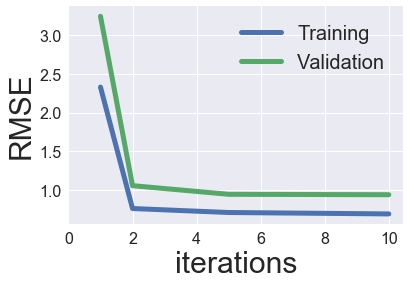

In [30]:
iter_array = [1, 2, 5, 10]
plot_learning_curve(iter_array, train, validation, 0.2, 10)

And finally, let's check the testing error.

In [31]:
predictions = final_model.predictAll(test.map(lambda x: (x[0], x[1]))) 
predictions = predictions.map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
print ('For testing data the RMSE is %s' % (error))

For testing data the RMSE is 0.907534155509


This is slightly better than the validation error (0.936).